## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib

from surfer import Brain
from mayavi import mlab

from tvtk.api import tvtk
from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = False

# %matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config


### Global Vars

In [2]:
subject_ID_col = 'SubjID'

### Data paths

In [3]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/Amadou/'
results_dir = data_dir + 'results/'

common_space = proj_dir + 'code/compare-surf-tools/config/fsaverage/'
demograph_file = 'ABIDE_Phenotype.csv'

outlier_QC_file = proj_dir + 'data/fs_output/fs60_vertex_out_sample/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_test20.csv'
    
#abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_test_nonzero.csv'

#abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_test20.csv'

brain_coef_file = data_dir + 'out_coef_est_left_right_hem_con.csv'



In [4]:
outlier_QC = pd.read_csv(outlier_QC_file,index_col=[0],header=None)
print(outlier_QC.shape)

mean_thickness = outlier_QC.mean(axis=0)
outlier_QC.head()

(20, 163842)


,1,2,3,4,5,6,7,8,9,10,...,163833,163834,163835,163836,163837,163838,163839,163840,163841,163842
0,,,,,,,,,,,,,,,,,,,,,
50822,3.208331,2.798306,3.128718,2.688519,2.316996,2.963104,1.657561,2.142612,0.0,2.212142,...,2.517141,2.473430,2.547213,2.339146,2.240880,2.369286,2.369286,2.146807,2.937431,2.469401
50804,3.061759,2.824523,3.282296,2.063624,2.627452,2.080930,1.793162,3.370214,0.0,2.785667,...,3.005616,3.005616,3.308608,3.235539,3.034177,2.756553,2.940214,2.940214,3.059146,2.693932
50785,3.006796,1.717444,3.108061,2.476269,3.298360,3.745053,2.522156,3.261147,0.0,3.809771,...,2.269003,2.678508,2.857566,2.857566,2.901811,2.162125,2.585969,2.901811,3.216961,3.191573
50824,3.227396,2.405693,2.835940,2.251794,2.970711,2.914946,2.480084,2.477637,0.0,3.136363,...,2.368923,2.524720,2.793200,2.969027,3.116255,2.811805,3.073762,3.233306,3.233306,3.085860
50788,2.697372,1.852928,2.135762,2.679585,2.768558,3.010654,2.030148,2.182316,0.0,2.998781,...,2.594051,2.620714,2.597672,2.425314,2.375470,2.941518,2.517521,2.468694,2.511143,2.460844


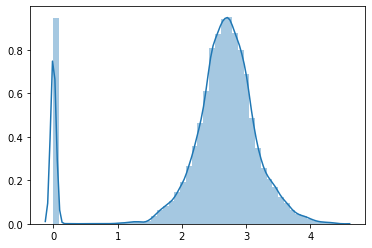

In [5]:
sns.distplot(mean_thickness)

In [35]:
brain_coef = pd.read_csv(brain_coef_file)
print(brain_coef.shape)
brain_coef.head()

(299881, 6)


,vertex_name,lasso_coef,asym_him_coef,asym_mip_coef,mip_coef,him_coef
0,vertex1,0.0,0.0,0.0,0.0,0.0
1,vertex2,0.0,0.0,0.0,0.0,0.0
2,vertex3,0.0,0.0,0.0,0.0,0.0
3,vertex4,0.0,0.0,0.0,0.0,0.0
4,vertex5,0.0,0.0,0.0,0.0,0.0


### Distribution of coefs

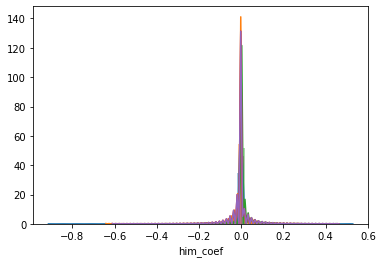

In [21]:
sns.distplot(brain_coef['lasso_coef'])
sns.distplot(brain_coef['asym_him_coef'])
sns.distplot(brain_coef['asym_mip_coef'])
sns.distplot(brain_coef['mip_coef'])
sns.distplot(brain_coef['him_coef'])


## PySurfer plots

In [37]:
def plot_vertex_maps(vertex_data, common_space, hemi, surf, view, cmap, save_path):

    b = Brain(common_space, hemi, surf, background="white",views=view)

    # co-ordinates
    x, y, z = b.geo[hemi].coords.T
    tris = b.geo[hemi].faces

    b.add_data(vertex_data,colormap=cmap, alpha=1, colorbar=True)

    print('Saving surface plot here: {}'.format(save_path))
    b.save_image(save_path)
    
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [46]:
surf = 'white' #'white' #"inflated"
subjects_dir = os.environ['SUBJECTS_DIR']

hemis = ['lh']
views = ['lateral','medial']

cmap = discrete_cmap(10,'YlOrBr') #plt.cmap('hot',10)

for hemi in hemis:
    for view in views:
        save_path = results_dir + 'CT_test_{}_{}.png'.format(hemi,view)        
        plot_vertex_maps(mean_thickness, common_space, hemi, surf, view, cmap, save_path)


colormap sequential: [0.00e+00, 2.24e+00, 4.48e+00] (opaque)
Saving surface plot here: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/Amadou/results/CT_test_lh_lateral.png
colormap sequential: [0.00e+00, 2.24e+00, 4.48e+00] (opaque)
Saving surface plot here: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/Amadou/results/CT_test_lh_medial.png
